In [574]:
import tweepy
import pandas as pd
import configparser
import re
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [575]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

In [576]:
api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

In [577]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [578]:
#posts = tweepy.Cursor(api.user_timeline, screen_name="ArvindKejriwal", count = 200, tweet_mode="extended").items((300))

In [579]:
posts = tweepy.Cursor(api.search_tweets, q="#bitcoin", count = 200, lang ="en", tweet_mode="extended").items((100))

In [580]:
df = pd.DataFrame([tweet.full_text for tweet in posts], columns=['Tweets'])

In [581]:
df

,Tweets
0,"RT @wahyutaklik: Finally, able to have a small..."
1,RT @Rebecca92164347: Wow these NFT from \n@Sol...
2,@BitcoinMagazine I would assume #Bitcoin is fr...
3,RT @michaelwrub: Coinbase partners with TurboT...
4,@BluesparrowC @davidgokhshtein @BlueSparrowETH...
...,...
95,RT @Rebecca92164347: Wow these NFT from \n@Sol...
96,RT @_bitcoiner: #BITCOIN 💎🙌\n\n@coinkit_ mon 3...
97,RT @Crypto_Mags: Want to work for a #Bitcoin c...
98,RT @MatthewHyland_: One of the key #Bitcoin in...


In [582]:
def extract(text):
    text = re.findall("(@[A-Za-z0–9\d\w]+)", text)
    return text

df["mention"] = df["Tweets"].apply(extract)


In [583]:
df['links'] = df['Tweets'].str.extract('(https?:\/\/\S+)', expand=False).str.strip()
df['retweets'] = df['Tweets'].str.extract('(RT[\s@[A-Za-z0–9\d\w]+)', expand=False).str.strip()

In [584]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [585]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub("\n","",text) 
    text = re.sub(":","",text) 
    text = re.sub("_","",text) 
    text = emoji_pattern.sub(r'', text)
    return text


# Clean the tweets
df['Tweets'] = df['Tweets'].apply(cleanTxt)
df['retweets'] = df['retweets'].str.replace(r"(RT )", "")
discard = ["CNFTGiveaway", "IVEAWAYPrizes", "Giveaway", "Airdrop"]
df = df[~df["Tweets"].str.contains('|'.join(discard))]

<ipython-input-585-bed636f836b2>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['retweets'] = df['retweets'].str.replace(r"(RT )", "")


In [586]:
df

,Tweets,mention,links,retweets
0,"Finally, able to have a small house to shelte...","[@wahyutaklik, @VitalikButerin]",NaN,@wahyutaklik
1,2164347 Wow these NFT from are absolutely cra...,"[@Rebecca92164347, @SolfNFT]",https://t.co/…,@Rebecca92164347
2,"I would assume Bitcoin is fraud as well, give...",[@BitcoinMagazine],NaN,NaN
3,Coinbase partners with TurboTax to let you re...,[@michaelwrub],NaN,@michaelwrub
4,Do you know in which token the next flight ...,"[@BluesparrowC, @davidgokhshtein, @BlueSparrow...",https://t.co/9s4N8QKbJX,NaN
...,...,...,...,...
95,2164347 Wow these NFT from are absolutely cra...,"[@Rebecca92164347, @SolfNFT]",https://t.co/…,@Rebecca92164347
96,@bitcoiner BITCOIN mon 37 1337 btc,"[@_bitcoiner, @coinkit_]",https://t.co/RNXuIoXday,@_bitcoiner
97,Mags Want to work for a Bitcoin company? Proof...,[@Crypto_Mags],NaN,@Crypto_Mags
98,One of the key Bitcoin indicators I have been...,[@MatthewHyland_],NaN,@MatthewHyland_


In [587]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df

<ipython-input-587-d444dd8f48c6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
<ipython-input-587-d444dd8f48c6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity'] = df['Tweets'].apply(getPolarity)


,Tweets,mention,links,retweets,Subjectivity,Polarity
0,"Finally, able to have a small house to shelte...","[@wahyutaklik, @VitalikButerin]",NaN,@wahyutaklik,0.512500,0.125
1,2164347 Wow these NFT from are absolutely cra...,"[@Rebecca92164347, @SolfNFT]",https://t.co/…,@Rebecca92164347,0.950000,-0.250
2,"I would assume Bitcoin is fraud as well, give...",[@BitcoinMagazine],NaN,NaN,0.000000,0.000
3,Coinbase partners with TurboTax to let you re...,[@michaelwrub],NaN,@michaelwrub,0.000000,0.000
4,Do you know in which token the next flight ...,"[@BluesparrowC, @davidgokhshtein, @BlueSparrow...",https://t.co/9s4N8QKbJX,NaN,0.333333,0.000
...,...,...,...,...,...,...
95,2164347 Wow these NFT from are absolutely cra...,"[@Rebecca92164347, @SolfNFT]",https://t.co/…,@Rebecca92164347,0.950000,-0.250
96,@bitcoiner BITCOIN mon 37 1337 btc,"[@_bitcoiner, @coinkit_]",https://t.co/RNXuIoXday,@_bitcoiner,0.000000,0.000
97,Mags Want to work for a Bitcoin company? Proof...,[@Crypto_Mags],NaN,@Crypto_Mags,0.000000,0.000
98,One of the key Bitcoin indicators I have been...,[@MatthewHyland_],NaN,@MatthewHyland_,0.750000,0.000


In [588]:
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)
# Show the dataframe
df

<ipython-input-588-5984e99df0d4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = df['Polarity'].apply(getAnalysis)


,Tweets,mention,links,retweets,Subjectivity,Polarity,Analysis
0,"Finally, able to have a small house to shelte...","[@wahyutaklik, @VitalikButerin]",NaN,@wahyutaklik,0.512500,0.125,Positive
1,2164347 Wow these NFT from are absolutely cra...,"[@Rebecca92164347, @SolfNFT]",https://t.co/…,@Rebecca92164347,0.950000,-0.250,Negative
2,"I would assume Bitcoin is fraud as well, give...",[@BitcoinMagazine],NaN,NaN,0.000000,0.000,Neutral
3,Coinbase partners with TurboTax to let you re...,[@michaelwrub],NaN,@michaelwrub,0.000000,0.000,Neutral
4,Do you know in which token the next flight ...,"[@BluesparrowC, @davidgokhshtein, @BlueSparrow...",https://t.co/9s4N8QKbJX,NaN,0.333333,0.000,Neutral
...,...,...,...,...,...,...,...
95,2164347 Wow these NFT from are absolutely cra...,"[@Rebecca92164347, @SolfNFT]",https://t.co/…,@Rebecca92164347,0.950000,-0.250,Negative
96,@bitcoiner BITCOIN mon 37 1337 btc,"[@_bitcoiner, @coinkit_]",https://t.co/RNXuIoXday,@_bitcoiner,0.000000,0.000,Neutral
97,Mags Want to work for a Bitcoin company? Proof...,[@Crypto_Mags],NaN,@Crypto_Mags,0.000000,0.000,Neutral
98,One of the key Bitcoin indicators I have been...,[@MatthewHyland_],NaN,@MatthewHyland_,0.750000,0.000,Neutral


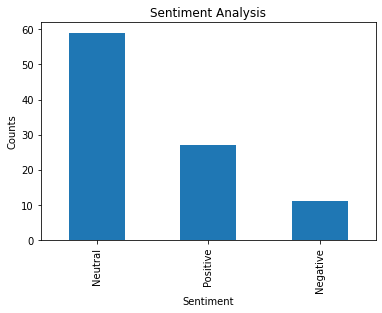

In [589]:


# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

